In [ ]:
# ----------------------------------------------------------------------
# 1. SETUP AND MOUNT GOOGLE DRIVE
# ----------------------------------------------------------------------
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully. ✅")

# Define the paths based on your structure: /content/drive/My Drive/Spoof_data/{train, test}/{live, spoof}/img.png
BASE_PATH = '/content/drive/My Drive/Spoof_data'
TRAIN_DIR = os.path.join(BASE_PATH, 'train') # Correctly points to /.../train/
TEST_DIR = os.path.join(BASE_PATH, 'test')   # Correctly points to /.../test/

# --- Model Parameters ---
IMG_WIDTH, IMG_HEIGHT = 128, 128
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 15
CLASS_NAMES = ['live', 'spoof']

# Verify the paths exist
if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
    print("\n--- CRITICAL ERROR ---")
    print(f"Directory not found. Please ensure 'train' and 'test' are in: {BASE_PATH}")
    raise FileNotFoundError("Check your Google Drive path and structure.")
else:
    print(f"Data directories set: \nTrain: {TRAIN_DIR}\nTest: {TEST_DIR}")

Mounted at /content/drive
Google Drive mounted successfully. ✅
Data directories set: 
Train: /content/drive/My Drive/Spoof_data/train
Test: /content/drive/My Drive/Spoof_data/test


In [ ]:
# Data augmentation for training data and normalization for both
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255) # Only normalization for test data

print("\nLoading training data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb' if CHANNELS == 3 else 'grayscale',
    shuffle=True
)

print("Loading testing data...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb' if CHANNELS == 3 else 'grayscale',
    shuffle=False # Crucial for evaluation
)

print(f"Class Indices (0/1 mapping): {train_generator.class_indices}")


Loading training data...
Found 407 images belonging to 2 classes.
Loading testing data...
Found 400 images belonging to 2 classes.
Class Indices (0/1 mapping): {'live': 0, 'spoof': 1}



Visualizing some training images after augmentation...


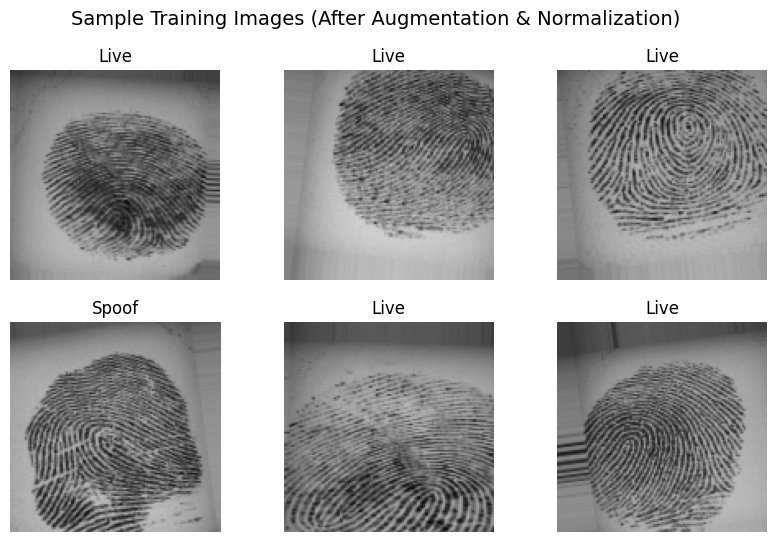

In [ ]:
# ----------------------------------------------------------------------
#VISUAL INSPECTION: AUGMENTED TRAINING IMAGES
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt

print("\nVisualizing some training images after augmentation...")

# Take one batch of training images
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"{'Live' if y_batch[i] == 0 else 'Spoof'}")
    plt.axis('off')

plt.suptitle("Sample Training Images (After Augmentation & Normalization)", fontsize=14)
plt.show()


In [ ]:
model = Sequential([
    # Input Block (64 filters)
    Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Increased dropout

    # Middle Block 1 (128 filters)
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Middle Block 2 (256 filters) - Deeper
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Classifier Head
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), # High dropout to regularize the dense layers
    Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',    # for 2-class output (0 or 1)
    metrics=['accuracy']
)
model.summary
print("\n--- Starting Model Training ---")
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)



--- Starting Model Training ---
Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7437 - loss: 0.8587 - val_accuracy: 0.5000 - val_loss: 0.9293
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 562ms/step - accuracy: 0.8715 - loss: 0.3485 - val_accuracy: 0.5000 - val_loss: 1.6324
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 623ms/step - accuracy: 0.9109 - loss: 0.2874 - val_accuracy: 0.5000 - val_loss: 2.1711
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 573ms/step - accuracy: 0.9061 - loss: 0.2813 - val_accuracy: 0.5000 - val_loss: 2.6893
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 581ms/step - accuracy: 0.9069 - loss: 0.1891 - val_accuracy: 0.5000 - val_loss: 2.4457
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.9103 - loss: 0.2251 - val_accuracy: 0.5000 - val_loss: 3.1202
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 583ms/step - accuracy: 0.8924 - loss: 0.2849 - val_accuracy: 0.5000 - val_loss: 3.1982
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 572ms/step - accuracy: 0.9255 -


Evaluating the best enhanced model...
Error loading model: File not found: filepath=/content/drive/My Drive/Spoof_data/best_enhanced_cnn_model.keras. Please ensure the file is an accessible `.keras` zip file.
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step

--- CLASSIFICATION REPORT (Enhanced Model) ---
              precision    recall  f1-score   support

        live       0.50      1.00      0.67       200
       spoof       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400


--- RAW CONFUSION MATRIX ---
[[200   0]
 [200   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


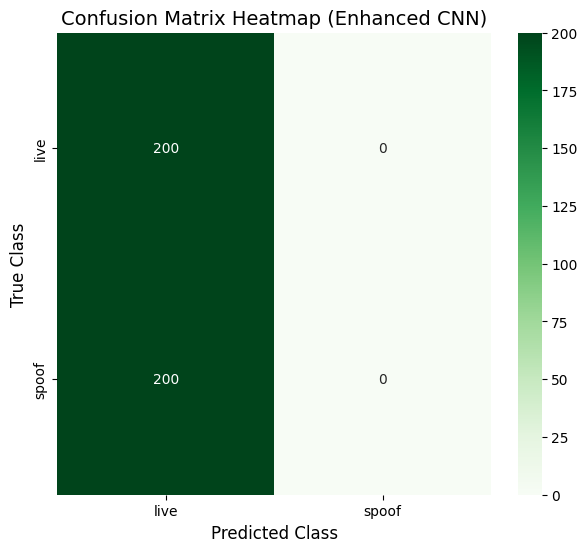

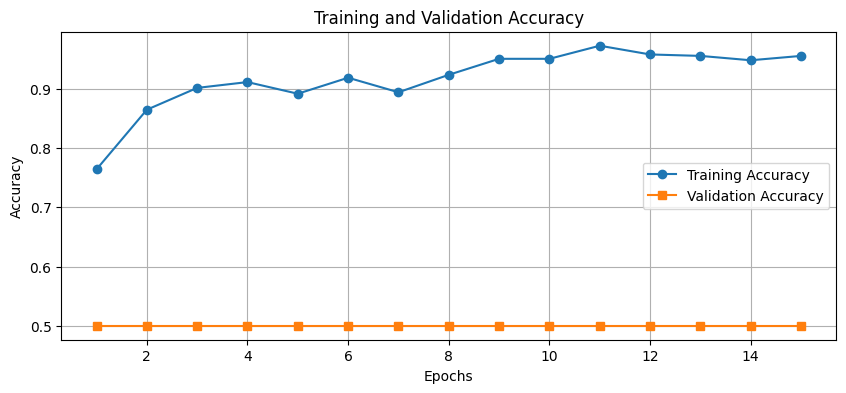

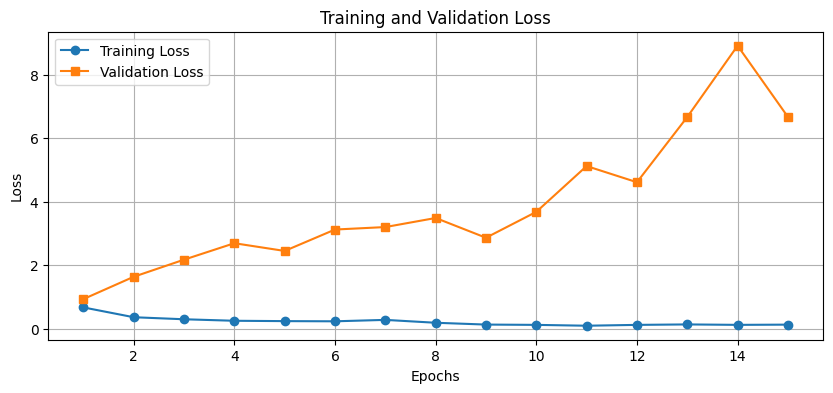


--- VISUALIZING SAMPLE PREDICTIONS ---


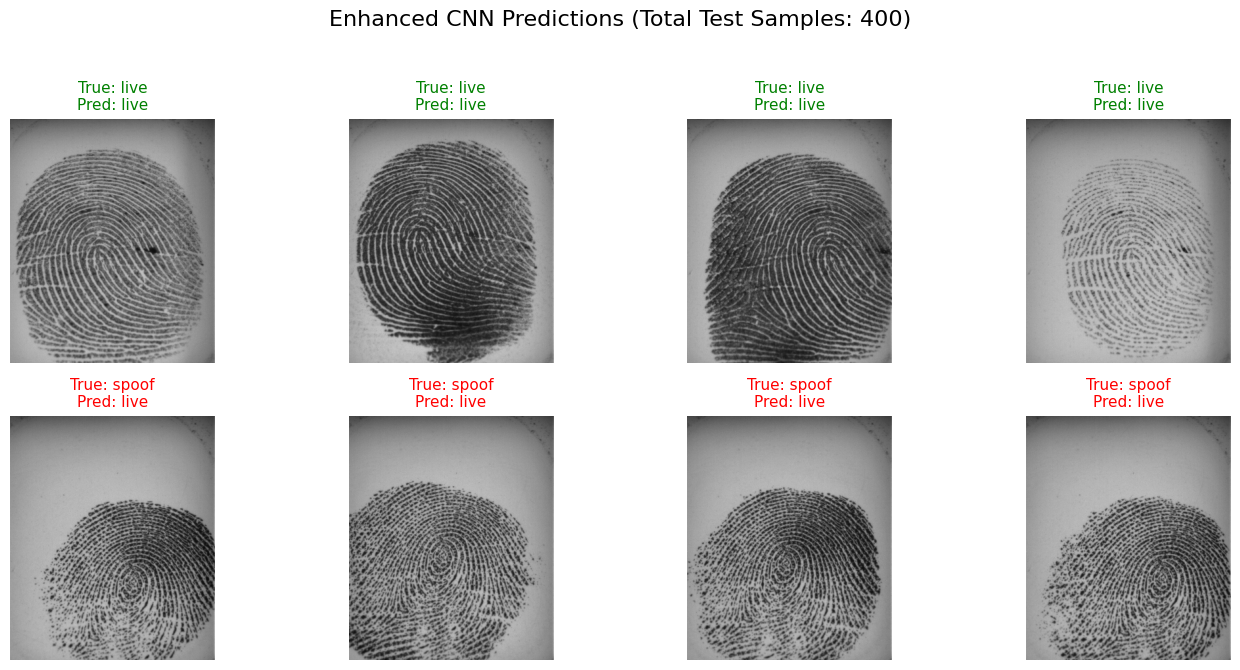


Best Model saved during training: /content/drive/My Drive/Spoof_data/best_enhanced_cnn_model.keras


In [ ]:
# ----------------------------------------------------------------------
# 5. EVALUATION, VISUALIZATION, AND SAVING (FINAL REPORT SECTION)
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model # Used to load the best model
# Re-define necessary variables (ensure these match your previous blocks)
checkpoint_filepath = os.path.join(BASE_PATH, 'best_enhanced_cnn_model.keras')
TEST_DIR = os.path.join(BASE_PATH, 'test') # Assuming BASE_PATH and TEST_DIR are still defined

print("\nEvaluating the best enhanced model...")

# Load the best model saved by ModelCheckpoint
try:
    best_model = load_model(checkpoint_filepath)
except Exception as e:
    print(f"Error loading model: {e}")
    print("WARNING: Falling back to the model currently in memory (results may vary).")
    # If the model couldn't be loaded (e.g., first time run failure), use the in-memory model (if defined)
    try:
        best_model = model
    except NameError:
        print("CRITICAL ERROR: Model variable 'model' not found. Cannot proceed with evaluation.")
        exit()


# Reset generator for clean prediction sequence
test_generator.reset()
# Predict on the entire test set
Y_pred = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert probabilities to class labels (0 or 1)
y_pred_classes = np.round(Y_pred).astype(int).flatten()

# Get true labels and slice to match the prediction size
y_true = test_generator.classes[:len(y_pred_classes)]

# Define target names based on the class indices for the report
target_names = [name for name, index in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# ----------------------------------------------------------------------
## 5.1. Classification Report and Confusion Matrix
# ----------------------------------------------------------------------

print("\n--- CLASSIFICATION REPORT (Enhanced Model) ---")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

print("\n--- RAW CONFUSION MATRIX ---")
print(cm)

# Confusion Matrix Visualization
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=target_names,
    yticklabels=target_names
)

plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.title('Confusion Matrix Heatmap (Enhanced CNN)', fontsize=14)
plt.ylim(len(target_names), 0)
plt.show()

# ----------------------------------------------------------------------
# 5.3. TRAINING & VALIDATION PERFORMANCE VISUALIZATION
# ----------------------------------------------------------------------

# This assumes you have the 'history' object from model.fit(...)
# If you trained your model earlier as:
# history = model.fit(train_generator, validation_data=val_generator, epochs=..., ...)
# then you can use that variable here.

try:
    # Extract training details
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Loss
    plt.figure(figsize=(10, 4))
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

except NameError:
    print("⚠️ 'history' object not found. Make sure you saved it during training as 'history = model.fit(...)'.")


# ----------------------------------------------------------------------
## 5.2. Visual Inspection of Predictions
# ----------------------------------------------------------------------

print("\n--- VISUALIZING SAMPLE PREDICTIONS ---")

# Determine the indices of correct and incorrect predictions
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Function to get the file paths for the indices
def get_file_paths(generator, indices, num_samples):
    """Retrieves file paths corresponding to prediction indices."""
    file_names = np.array(generator.filenames)
    return file_names[indices[:num_samples]]

# Grab 4 correctly predicted and 4 incorrectly predicted image file paths (as requested 'd' examples)
num_samples = 4 # Changed to 4 for 'd' visual examples
correct_files = get_file_paths(test_generator, correct_indices, num_samples)
incorrect_files = get_file_paths(test_generator, incorrect_indices, num_samples)

# Setup the visualization plot (2 rows, 4 columns)
fig, axes = plt.subplots(2, num_samples, figsize=(14, 7))
fig.suptitle(f'Enhanced CNN Predictions (Total Test Samples: {test_generator.samples})', fontsize=16)

# Map class index back to class name
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Function to load and plot image
def plot_image(ax, file_path, true_label, pred_label, is_correct):
    """Loads and plots a single image with prediction details."""
    img_path = os.path.join(TEST_DIR, file_path)
    img = plt.imread(img_path)
    ax.imshow(img)

    color = 'green' if is_correct else 'red'
    title = f'True: {true_label}\nPred: {pred_label}'
    ax.set_title(title, color=color, fontsize=11)
    ax.axis('off')

# Plot Correct Predictions (Row 1)
for i, file_path in enumerate(correct_files):
    idx = correct_indices[i]
    true_label = idx_to_class[y_true[idx]]
    pred_label = idx_to_class[y_pred_classes[idx]]
    plot_image(axes[0, i], file_path, true_label, pred_label, True)
axes[0, 0].set_ylabel('Correct Predictions', rotation=90, size=14, labelpad=15)


# Plot Incorrect Predictions (Row 2)
for i, file_path in enumerate(incorrect_files):
    if i >= len(incorrect_indices): # Handle case where there might be fewer than 4 errors
        fig.delaxes(axes[1, i])
        continue

    idx = incorrect_indices[i]
    true_label = idx_to_class[y_true[idx]]
    pred_label = idx_to_class[y_pred_classes[idx]]
    plot_image(axes[1, i], file_path, true_label, pred_label, False)
axes[1, 0].set_ylabel('Incorrect Predictions (Errors)', rotation=90, size=14, labelpad=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final saving confirmation
print(f"\nBest Model saved during training: {checkpoint_filepath}")